# Classical ML Methods: Random Forest

## Packages and Presets

In [1]:
import pandas as pd
import numpy as np
import yaml
from icecream import ic
import os
import joblib

from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report
)


from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

from tsfresh.transformers.per_column_imputer import PerColumnImputer
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.feature_extraction import extract_features


pd.set_option('display.max_columns', None)
%load_ext blackcellmagic
%load_ext autoreload

import warnings
warnings.filterwarnings("ignore") # sanest python user

In [2]:
with open("classical_ml_config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Performance Without Feature Engineering

Preprocessing data: Since the data is already clean, we only need to split it into training and testing sets. Moreover, all the feature values lie between 0 and 1, so we do not see the need to scale them.

In [3]:
# Load data
train_df = pd.read_csv(config["paths"]["ptb_train"], header=None)
test_df = pd.read_csv(config["paths"]["ptb_test"], header=None)

In [4]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]


X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [5]:
# sm = SMOTE(random_state=config["general"]["seed"])
# X_train, y_train = sm.fit_resample(X_train, y_train)
# ic(X_train.shape, y_train.shape)
# ic(np.unique(y_train, return_counts=True))

In [6]:
rf_no_feat_eng = RandomForestClassifier(
    n_estimators=config["random_forest_no_feat_eng"]["n_estimators"],
    max_depth=config["random_forest_no_feat_eng"]["max_depth"],
    min_samples_leaf=config["random_forest_no_feat_eng"]["min_samples_leaf"],
    max_features=config["random_forest_no_feat_eng"]["max_features"],
    bootstrap=config["random_forest_no_feat_eng"]["bootstrap"],
    criterion=config["random_forest_no_feat_eng"]["criterion"],
    random_state=config["general"]["seed"],
    n_jobs=-1,
)

In [7]:
rf_no_feat_eng.fit(X_train, y_train)

In [ ]:
joblib.dump(rf_no_feat_eng, config["paths"]["rf_no_feat_eng"])

['../weights/catboost_no_feat_eng.pkl']

In [ ]:
y_preds = rf_no_feat_eng.predict(X_test)

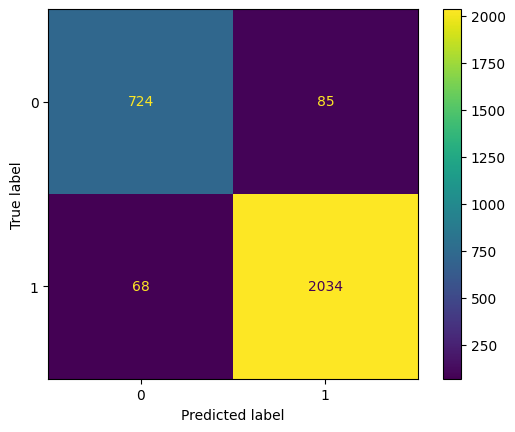

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [ ]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.947441
Test balanced accuracy: 0.931291
Test f1 score: 0.963753
Test precision: 0.959887
Test recall: 0.967650


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       809
         1.0       0.96      0.97      0.96      2102

    accuracy                           0.95      2911
   macro avg       0.94      0.93      0.93      2911
weighted avg       0.95      0.95      0.95      2911



## Performance with Feature Engineering

First, RelevantFeatureAugmenter requires the column names to be strings. Thus, we first have to convert the column names to strings:

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
rf_feat_eng = RandomForestClassifier(
    n_estimators=config["random_forest_feat_eng"]["n_estimators"],
    max_depth=config["random_forest_feat_eng"]["max_depth"],
    min_samples_leaf=config["random_forest_feat_eng"]["min_samples_leaf"],
    max_features=config["random_forest_feat_eng"]["max_features"],
    bootstrap=config["random_forest_feat_eng"]["bootstrap"],
    criterion=config["random_forest_feat_eng"]["criterion"],
    random_state=config["general"]["seed"],
    n_jobs=-1,
)

In the following, we will use the `tsfresh` library (see [here](https://tsfresh.readthedocs.io/en/latest/)) to extract features from the time series data. We will then train a CatBoostClassifier on the extracted features and evaluate the model performance. For using the `tsfresh` library, we first have to bring our data into the correct format:

In [ ]:
# melt the training dataframe
X_train_copy = X_train.copy(deep=True)
X_train_copy["id"] = X_train_copy.index
X_train_melted =(
    X_train_copy
    .melt(id_vars="id", var_name="time", value_name="value")
    .sort_values(by=["id", "time"])
)
# get rid of padding to not ruin the engineered features
# for simplicity, we drop all 0s, as only few "true" 0s are in the data
X_train_melted["value"] = X_train_melted["value"].replace(0, np.nan)
X_train_melted = X_train_melted.dropna()

# melt the test dataframe
X_test_copy = X_test.copy(deep=True) 
X_test_copy["id"] = X_test_copy.index
X_test_melted =(
    X_test_copy
    .melt(id_vars="id", var_name="time", value_name="value")
    .sort_values(by=["id", "time"])
)
# get rid of padding to not ruin the engineered features
# for simplicity, we drop all 0s, as only few "true" 0s are in the data
X_test_melted["value"] = X_test_melted["value"].replace(0, np.nan)
X_test_melted = X_test_melted.dropna()

In [ ]:
# We will follow this tutorial:
# https://towardsdatascience.com/expanding-your-regression-repertoire-with-regularisation-903d2c9f7b28
# but will use the ComprehensiveFCParameters instead of the EfficientFCParameters
# for feature extraction
X_train_augmented = extract_features(
    X_train_melted,
    column_id="id",
    column_sort="time",
    column_value="value",
    default_fc_parameters=ComprehensiveFCParameters(),
)  
X_test_augmented = extract_features(
    X_test_melted,
    column_id="id",
    column_sort="time",
    column_value="value",
    default_fc_parameters=ComprehensiveFCParameters(),
)  

Feature Extraction: 100%|██████████| 79/79 [00:14<00:00,  5.62it/s]


In [ ]:
X_train_merged = pd.merge(
    X_train, X_train_augmented, left_index=True, right_index=True
)
X_test_merged = pd.merge(
    X_test, X_test_augmented, left_index=True, right_index=True
)

# assert that no rows were lost
assert X_train_merged.shape[0] == X_train.shape[0]
assert X_test_merged.shape[0] == X_test.shape[0]
assert X_train_merged.index.equals(X_train.index)
assert X_test_merged.index.equals(X_test.index)

In [ ]:
imputer = PerColumnImputer()
X_train_merged = imputer.fit_transform(X_train_merged)
X_test_merged = imputer.transform(X_test_merged)

In [ ]:
rf_feat_eng.fit(X_train_merged, y_train)
y_preds = rf_feat_eng.predict(X_test_merged)

In [ ]:
joblib.dump(rf_feat_eng, config["paths"]["rf_feat_eng"])

['../weights/catboost_feat_eng.pkl']

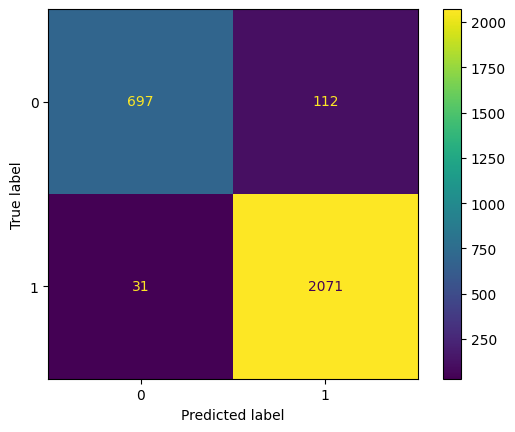

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [ ]:
# calculate precision and recall:
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Test accuracy: {accuracy_score(y_test, y_preds):.6f}")
print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, y_preds):.6f}")
print(f"Test f1 score: {f1_score(y_test, y_preds):.6f}")
print(f"Test precision: {precision:.6f}")
print(f"Test recall: {recall:.6f}")

Test accuracy: 0.950876
Test balanced accuracy: 0.923405
Test f1 score: 0.966628
Test precision: 0.948694
Test recall: 0.985252


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91       809
         1.0       0.95      0.99      0.97      2102

    accuracy                           0.95      2911
   macro avg       0.95      0.92      0.94      2911
weighted avg       0.95      0.95      0.95      2911

